# Importing Libraries

In [ ]:
basePath = '/content/drive/MyDrive/BP_And_Speech_Analysis/';

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler

from IPython.display import display 

# Importing Patient Meta Data and Basic Preprocessing of Dataframe

In [ ]:
directory = "PreprocessedData/"
#Reading the patient data
patientTrain = pd.read_csv(basePath + directory + 'patientTrain.csv');
trainFileNames = patientTrain["FileName"];
patientTest = pd.read_csv(basePath + directory + 'patientTest.csv');
testFileNames = patientTest["FileName"];

#Combining the train and test meta data for basic preprocessing
testIndex = patientTrain.shape[0];
Combined = patientTrain.append(patientTest);


Combined = Combined.drop(columns= ["FileName", "HeartbeatRate"])
dtype_dict = {'Gender' : 'category',
              'Age' : 'float64',
              'Weight': 'float64',
              'Size' : 'float64',
              'SystolicBP': 'float64',
              'DiastolicBP': 'float64'};
Combined = Combined.astype(dtype_dict);
Combined.rename(columns= {'Size' : 'Height'}, inplace=True);


#One-hot encoding categorical feature 'Gender'
genderBinarizer = LabelBinarizer().fit(Combined["Gender"])
Combined["Gender"] = genderBinarizer.transform(Combined["Gender"])

#Separating the data back into test and train dataframes
patientTrain = Combined.iloc[0:testIndex];
patientTest = Combined.iloc[testIndex : ];

#Separating predictors and response variables
Xtrain = patientTrain[["Gender", "Age", "Weight", "Height"]];
Ytrain = patientTrain[["SystolicBP", "DiastolicBP"]];

Xtest = patientTest[["Gender", "Age", "Weight", "Height"]];
Ytest = patientTest[["SystolicBP", "DiastolicBP"]];

#Separating the predictors into continuous and categorical features inorder to  
#standardize the continuous features separately
continuous = ["Age", "Weight", "Height"];
categorical = ["Gender"];

trainCategorical = Xtrain[categorical];
trainContinuous = Xtrain[continuous];

testCategorical = Xtest[categorical];
testContinuous = Xtest[continuous];

#Standardization of continuous features
Xscaler = StandardScaler().fit(trainContinuous);
trainContinuous = Xscaler.transform(trainContinuous);
testContinuous = Xscaler.transform(testContinuous);

#Combining the predictors
Xtrain = np.hstack((trainContinuous,  trainCategorical.to_numpy()));
Xtest = np.hstack((testContinuous, testCategorical.to_numpy()));

#Standardizing Response Variables
Yscaler = StandardScaler().fit(Ytrain);
Ytrain = Yscaler.transform(Ytrain);
Ytest = Yscaler.transform(Ytest);


# Data Visualization Section

Plots to gain better understanding of the data in the tables

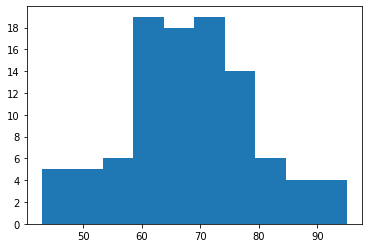

In [ ]:
#Plotting Diastolic Blood Pressure Distribution
ax = plt.figure().gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.hist(patientTrain["DiastolicBP"]);

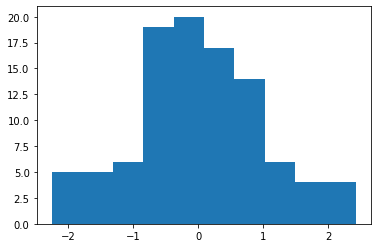

In [ ]:
#After preprocessing
plt.hist(Ytrain[:, 1]);

# Importing the Preprocessed Audio Data

In this section, we load the audio data of the patients. The .csv files were obtained after preprocessing the .wav files, extracting features, and normalizing the audio features using MATLAB.

In [ ]:
numTrain = Xtrain.shape[0];
numTest = Xtest.shape[0];

#Using pre-defined the audioTrain matrix to speed up loading.
#On using a list, its size will have to change dynamically, which will slow down
#the loading
directory = "PreprocessedData/TrainFiles/";
audioTrain = np.zeros([numTrain, 512, 711], dtype = np.float64);
for i in range(numTrain):
  audioTrain[i, :, :] = pd.read_csv(basePath + directory + trainFileNames[i] + ".csv", header = None).to_numpy();
  #Remember to set header = None, otherwise the first row of the matrix will be assumed to contain column names,
  # and hence will be neglected

#Similarly, loading the test audio feature files
directory = "PreprocessedData/TestFiles/";
audioTest = np.zeros([numTest, 512, 711], dtype = np.float64);
for i in range(numTest):
  audioTest[i, :, :] = pd.read_csv(basePath + directory + testFileNames[i] + ".csv", header = None).to_numpy();

#Adding dummy channels
audioTrain = audioTrain[..., np.newaxis];
audioTest = audioTest[..., np.newaxis];

#Checking whether the data is loaded into correct shapes or not
print("Train file shapes: \n", audioTrain[0].shape);
print(audioTrain.shape);
print("Train file shapes: \n", audioTest[0].shape);
print(audioTest.shape);

Train file shapes: 
 (512, 711, 1)
(100, 512, 711, 1)
Train file shapes: 
 (512, 711, 1)
(14, 512, 711, 1)


# Developing a Multi-Input Neural Network

Our model should accept numeric, categorical, and image-like (audio) features. So we develop a neural network with 2 branches:

1.   Convolutional Neural Network (CNN)
2.   Multi Layer Perceptron (MLP)

The output of the branches are concatenated and fed to a MLP with a Regression Layer at the end.

This is a multi-output regression since both Diastolic and Systolic blood presures have to be predicted.

Reference: [https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/](https://)

In [ ]:
#Importing necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from keras.utils.vis_utils import plot_model

In [ ]:
#Defining a function to generate the MLP branch of the network
#State: 4(in) -> 8 -> 4(out)
def create_mlp(input_dim, regress=False) :
  
  model = Sequential();
  model.add(Dense(8, input_dim=input_dim, activation="relu"));
  model.add(Dense(4, activation="relu"));

  if(regress) :
    model.add(Dense(2, activation="linear"));

  return model;  

In [ ]:
#Defining a function to generate the CNN brnach of the network
def create_cnn(height, width, depth, filters=(16, 32, 64, 128), regress=False):

	# initialize the input shape and channel dimension, assuming
	# TensorFlow/channels-last ordering
	inputShape = (height, width, depth)
	chanDim = -1

	# define the model input
	inputs = Input(shape=inputShape)
 
	# loop over the number of filters
	for (i, f) in enumerate(filters):
   
		# if this is the first CONV layer then set the input
		# appropriately
		if i == 0:
			x = inputs

		# CONV => RELU => BN => POOL
		x = Conv2D(f, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
  
  # flatten the volume, then FC => RELU => BN => DROPOUT
	x = Flatten()(x)
	x = Dense(16)(x)
	x = Activation("relu")(x)
	x = BatchNormalization(axis=chanDim)(x)
	x = Dropout(0.5)(x)
 
	# apply another FC layer, this one to match the number of nodes
	# coming out of the MLP
	x = Dense(4)(x)
	x = Activation("relu")(x)
 
	# check to see if the regression node should be added
	if regress:
		x = Dense(2, activation="linear")(x)
  
	# construct the CNN
	model = Model(inputs, x)
	# return the CNN
	return model

In [ ]:
# create the MLP and CNN models
mlp = create_mlp(4, regress=False)
cnn = create_cnn(512, 711, 1, regress=False)

# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])

# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(2, activation="linear")(x)

# our final model will accept categorical/numerical data on the MLP
# input and audio feature matrices on the CNN input, outputting 2 values (Diastolic and
#Systolic Blood Pressures) 
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

In [ ]:
# compile the model using mean absolute percentage error as our loss
mse = MeanSquaredError()
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss='mae', optimizer='adam')

In [ ]:
# train the model
print("[INFO] training model...")
model.fit(
	x=[Xtrain, audioTrain], y=Ytrain,
	validation_data=([Xtest, audioTest], Ytest),
	epochs=100, batch_size=None)
# make predictions on the testing data
print("[INFO] predicting Blood Pressures...")
preds = model.predict([Xtest, audioTest])

[INFO] training model...
Epoch 1/100
4/4 [==============================] - 10s 491ms/step - loss: 0.9533 - val_loss: 1.0472
Epoch 2/100
4/4 [==============================] - 1s 191ms/step - loss: 0.8972 - val_loss: 0.9662
Epoch 3/100
4/4 [==============================] - 1s 227ms/step - loss: 0.8467 - val_loss: 0.9605
Epoch 4/100
4/4 [==============================] - 1s 193ms/step - loss: 0.8677 - val_loss: 0.9809
Epoch 5/100
4/4 [==============================] - 1s 190ms/step - loss: 0.8970 - val_loss: 1.0495
Epoch 6/100
4/4 [==============================] - 1s 190ms/step - loss: 0.8394 - val_loss: 1.1638
Epoch 7/100
4/4 [==============================] - 1s 190ms/step - loss: 0.8394 - val_loss: 1.2408
Epoch 8/100
4/4 [==============================] - 1s 190ms/step - loss: 0.8408 - val_loss: 1.3630
Epoch 9/100
4/4 [==============================] - 1s 190ms/step - loss: 0.7862 - val_loss: 1.5673
Epoch 10/100
4/4 [==============================] - 1s 189ms/step - loss: 0.8094 - 

In [ ]:
deviations = Yscaler.inverse_transform(Ytest) - Yscaler.inverse_transform(preds)
performance_eval_table = pd.DataFrame(np.hstack((Yscaler.inverse_transform(Ytest), Yscaler.inverse_transform(preds), deviations)), columns=["Diastolic", "Systolic", "Pred_Diastolic", "Pred_Systolic", "Dev_Diastolic", "Dev_Systolic"])
display(performance_eval_table)

,Diastolic,Systolic,Pred_Diastolic,Pred_Systolic,Dev_Diastolic,Dev_Systolic
0,136.0,112.0,106.754173,65.627159,29.245827,46.372841
1,114.0,75.0,142.630493,80.515320,-28.630493,-5.515320
2,104.0,59.0,138.598679,70.335442,-34.598679,-11.335442
3,138.0,73.0,115.126808,65.815018,22.873192,7.184982
4,106.0,50.0,116.283974,65.840981,-10.283974,-15.840981
5,119.0,68.0,120.151680,68.697052,-1.151680,-0.697052
6,105.0,54.0,123.221962,68.324501,-18.221962,-14.324501
7,137.0,80.0,100.016891,65.475998,36.983109,14.524002
8,149.0,68.0,105.441055,65.597694,43.558945,2.402306
9,111.0,59.0,112.240417,72.229561,-1.240417,-13.229561


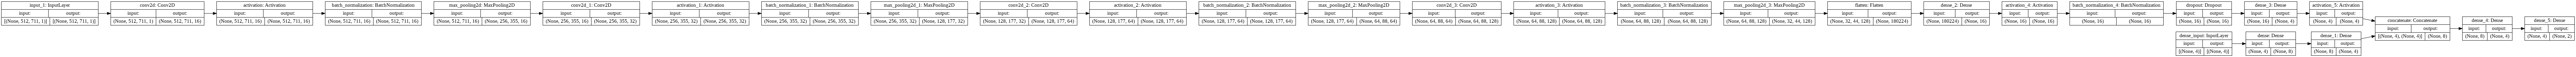

In [ ]:
#model.save(basePath + "trialModel.h5")
plot_model(model, to_file=basePath + "network_graph.png", show_layer_names=True, show_shapes=True, rankdir="LR")